In [2]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1+cu117 --user -f https://download.pytorch.org/whl/cu117/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu117/torch_stable.html


In [3]:
import pandas as pd

In [4]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer,RobertaTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from transformers import RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer

df = pd.read_csv('C:/Users/JenMing/Desktop/MBTI/MBTI_test.csv')
df.head()

,type,posts
0,INFJ,What has been the most life-changing experienc...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,"Of course, to which I say I know; that's my bl..."
3,INTJ,"'Dear certain personality, I enjoyed our con..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
import string
import re

def clean_text(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    words = str(text).split()
    #words = [i.lower() + " " for i in words]
    #words = [i for i in words if not "http" in i]
    words = " ".join(words)
    #words = words.translate(words.maketrans('', '', string.punctuation))
    return words

df['posts'] = df['posts'].apply(clean_text)

In [6]:
# 檢查是否有可用的GPU
print(torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda")    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

True
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [7]:
torch.cuda.empty_cache()

In [8]:
df['type'].value_counts()

INFP    1832
INFJ    1469
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [9]:
possible_labels = df.type.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'INFJ': 0,
 'ENTP': 1,
 'INTP': 2,
 'INTJ': 3,
 'ENTJ': 4,
 'ENFJ': 5,
 'INFP': 6,
 'ENFP': 7,
 'ISFP': 8,
 'ISTP': 9,
 'ISFJ': 10,
 'ISTJ': 11,
 'ESTP': 12,
 'ESFP': 13,
 'ESTJ': 14,
 'ESFJ': 15}

In [10]:
df['label'] = df.type.replace(label_dict)

In [11]:
type_index_mapping = {
    'ESTJ': '0000',
    'ISTJ': '1000',
    'INTJ': '1100',
    'INFJ': '1110',
    'INFP': '1111',
    'INTP': '1101',
    'ISTP': '1001',
    'ISFJ': '1010',
    'ISFP': '1011',
    'ESTP': '0001',
    'ESFJ': '0010',
    'ESFP': '0011',
    'ENTJ': '0100',
    'ENFP': '0111',
    'ENTP': '0101',
    'ENFJ': '0110'
}

df['type_index'] = df['type'].replace(type_index_mapping)

In [12]:
df.head()

,type,posts,label,type_index
0,INFJ,What has been the most life-changing experienc...,0,1110
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0101
2,INTP,"Of course, to which I say I know; that's my bl...",2,1101
3,INTJ,"'Dear certain personality, I enjoyed our conve...",3,1100
4,ENTJ,'You're fired. That's another silly misconcept...,4,0100


In [13]:
from sklearn.model_selection import train_test_split

#在資料集裡面, 我們會選取特徵 (就是"x") , 對應特徵的部分, 會有 Label (標記), (就是"y")
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

#old
#df['data_type'] = ['not_set']*df.shape[0]

#df.loc[X_train, 'data_type'] = 'train'
#df.loc[X_val, 'data_type'] = 'val'

#df.groupby(['type', 'label', 'data_type']).count()

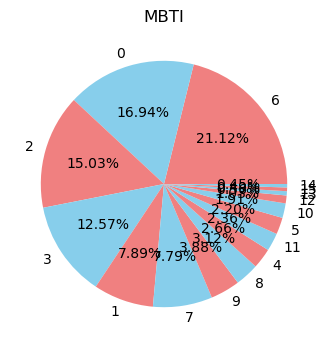

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure( figsize=(10,4) )
y_train_pd = pd.Series(y_train)
y_train_pd.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'MBTI' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [15]:
#上採樣
from imblearn.over_sampling import SMOTE
X_train_re = np.array(X_train).reshape(-1, 1)
y_train_re = np.array(y_train).reshape(-1, 1)
X_train_SM, y_train_SM = SMOTE().fit_resample(X_train_re, y_train_re)

X_val_re = np.array(X_val).reshape(-1, 1)
y_val_re = np.array(y_val).reshape(-1, 1)
X_val_SM, y_val_SM = SMOTE().fit_resample(X_val_re, y_val_re)

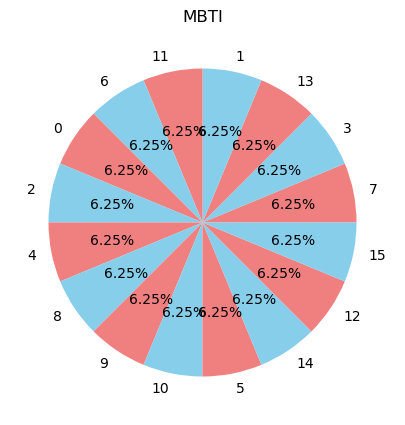

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure( figsize=(10,5) )
y_train_pd = pd.Series(y_train_SM)
y_train_pd.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'MBTI' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [17]:
#下採樣
from imblearn.under_sampling import TomekLinks
X_train_res, y_train_res = TomekLinks().fit_resample(X_train_SM, y_train_SM)
X_val_res, y_val_res = TomekLinks().fit_resample(X_val_SM, y_val_SM)

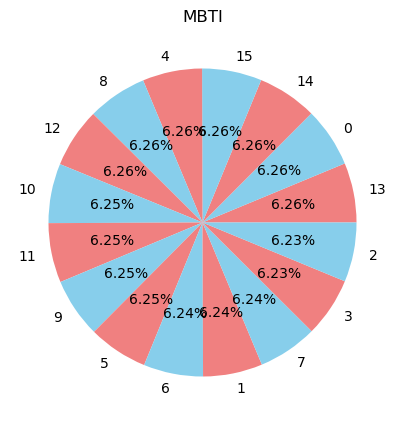

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure( figsize=(10,5) )
y_train_pd = pd.Series(y_train_res)
y_train_pd.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'MBTI' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [19]:
df['data_type'] = ['not_set']*df.shape[0]

X_train_flat = X_train_res.flatten()
X_val_flat = X_val_res.flatten()

df.loc[X_train_flat, 'data_type'] = 'train'
df.loc[X_val_flat, 'data_type'] = 'val'

df.groupby(['type', 'label', 'data_type']).count()

posts  type_index
type label data_type                   
ENFJ 5     not_set        3           3
           train        149         149
           val           38          38
ENFP 7     not_set        7           7
           train        489         489
           val          179         179
ENTJ 4     not_set        4           4
           train        167         167
           val           60          60
ENTP 1     not_set       10          10
           train        486         486
           val          189         189
ESFJ 15    train         32          32
           val           10          10
ESFP 13    not_set        1           1
           train         33          33
           val           14          14
ESTJ 14    train         30          30
           val            9           9
ESTP 12    train         70          70
           val           19          19
INFJ 0     train       1003        1003
           val          466         466
INFP 6     not_set       25          25
           train       1337        1337
           val          470         470
INTJ 3     not_set       11          11
           train        775         775
           val          305         305
INTP 2     not_set       14          14
           train        935         935
           val          355         355
ISFJ 10    not_set        3           3
           train        115         115
           val           48          48
ISFP 8     not_set        3           3
           train        197         197
           val           71          71
ISTJ 11    not_set        4           4
           train        147         147
           val           54          54
ISTP 9     not_set        4           4
           train        239         239
           val           94          94

In [24]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', 
#                                          do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].posts.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].posts.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt',
    truncation=True
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [20]:
count = 0
for i, n in enumerate(df['posts']):
    if type(n) != str:
        count += 1
        print(f"非字符串值的索引：{i}")
print(f"共有 {count} 個非字符串值")

共有 0 個非字符串值


In [21]:
from transformers import BertConfig
import torch.nn as nn

#config = RobertaConfig.from_pretrained('roberta-base', num_labels=len(label_dict),output_attentions=False,
#                                                      output_hidden_states=False)
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(label_dict),output_attentions=False,
                                                      output_hidden_states=False)
config.hidden_dropout_prob = 0.1
config.attention_probs_dropout_prob = 0.1

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
#--- transformer ---
#import torch.nn as nn
# 获取BERT模型的输出维度
#hidden_size = model.config.hidden_size

#transformer_classifier = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4)
#model.classifier = transformer_classifier
# --- LSTM ---
#import torch.nn as nn
#class LSTMClassifier(nn.Module):
#    def __init__(self, input_size, hidden_size, num_classes):
#        super(LSTMClassifier, self).__init__()
#        self.hidden_size = hidden_size
#        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#        self.fc = nn.Linear(hidden_size, num_classes)
#    def forward(self, x):
#        _, (h_n, _) = self.lstm(x)
#        output = self.fc(h_n[-1])
#        return output

#num_classes = 16
    
# 获取BERT模型的输出维度
#hidden_size = model.config.hidden_size

# 创建LSTM分类器
#lstm_classifier = LSTMClassifier(hidden_size, hidden_size, num_classes)

# 替换BERT模型的分类器为LSTM分类器
#model.classifier = lstm_classifier

#--- softmax ---

# 替換classifier的最後一層為一個全連接層
#num_classes = 16  # 目標類別數量
#model.classifier.out_proj = torch.nn.Linear(config.hidden_size, num_classes)
#model.classifier.dropout = torch.nn.Dropout(config.hidden_dropout_prob)

# 添加softmax層
#model.softmax = torch.nn.Softmax(dim=1)

#config = BertConfig(dropout=0.3)
#model = BertForSequenceClassification.from_pretrained("bert-large-uncased",
#                                                      num_labels=len(label_dict),
#                                                      output_attentions=False,
#                                                      output_hidden_states=False)

#import torch.nn as nn
# 修改 BERT 模型的最後一層
#model.classifier = nn.Sequential(
#    nn.Dropout(0.1),  # 新增 dropout 層
#    nn.Linear(model.config.hidden_size, len(label_dict)),  # 輸出層
#    nn.Softmax(dim=1)  # 新增 softmax 函數
#)

#---L2正則化---
# 添加L2正则化到模型的所有参数
#l2_reg = 0.01  # 调整正则化强度
# 在模型的参数中添加L2正则化项
#for name, param in model.named_parameters():
#    if 'bias' not in name:  # 排除偏置项
#        param.data = param.data.add(-l2_reg * param.data)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [22]:
print(torch.cuda.memory_allocated()/ 1073741824)
print(torch.cuda.max_memory_allocated()/ 1073741824)

print(f"Max memory of GPU 0: {torch.cuda.get_device_properties(0).total_memory / 1024**3} GB")

0.40896177291870117
0.40896177291870117
Max memory of GPU 0: 10.99969482421875 GB


In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 12

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8,
                  correct_bias=False)
                  
epochs = 20

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

C:\Users\JenMing\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/ 1073741824)
print(torch.cuda.max_memory_allocated()/ 1073741824)

print(f"Max memory of GPU 0: {torch.cuda.get_device_properties(0).total_memory / 1024**3} GB")

0.40896177291870117
0.40896177291870117
Max memory of GPU 0: 10.99969482421875 GB


In [26]:
def accuracy_per_class_index(list_to_convert):
    index_mapping = {
        0: '1110',
        1: '0101',
        2: '1101',
        3: '1100',
        4: '0100',
        5: '0110',
        6: '1111',
        7: '0111',
        8: '1011',
        9: '1001',
        10: '1010',
        11: '1000',
        12: '0001',
        13: '0011',
        14: '0000',
        15: '0010'
    }

    # 將數字列表轉換為對應的MBTI類別列表
    index_map_list = [index_mapping[i] for i in list_to_convert]

    return index_map_list


In [27]:
def count_acc(preds,labels,d,r):
    preds_tmp = preds//d
    labels_tmp = labels//d
    preds_tmp = preds_tmp%r
    labels_tmp = labels_tmp%r
    if preds_tmp == labels_tmp:
        return True

In [28]:
def accuracy_per_class_pk(preds, labels, opt_save_dic, f):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    preds_convert = accuracy_per_class_index(preds_flat)
    labels_convert = accuracy_per_class_index(labels_flat)
    EI_count = 0
    SN_count = 0
    TF_count = 0
    JP_count = 0
    for n in range(len(preds_convert)):
        preds_tmp = int(preds_convert[n])
        labels_tmp = int(labels_convert[n])
        JP_count_bool = count_acc(preds_tmp,labels_tmp,1,10)
        if JP_count_bool == True:
            JP_count += 1
        TF_count_bool = count_acc(preds_tmp,labels_tmp,10,10)
        if TF_count_bool == True:
            TF_count += 1
        SN_count_bool = count_acc(preds_tmp,labels_tmp,100,10)
        if SN_count_bool == True:
            SN_count += 1    
        EI_count_bool = count_acc(preds_tmp,labels_tmp,1000,10)
        if EI_count_bool == True:
            EI_count += 1    

    print(f'E.I: {EI_count}/{len(preds_convert)}')
    print('Accuracy: '+ str(EI_count/len(preds_convert))+'\n')
    print(f'S.N: {SN_count}/{len(preds_convert)}')
    print('Accuracy: '+ str(SN_count/len(preds_convert))+'\n')
    print(f'T.F: {TF_count}/{len(preds_convert)}')
    print('Accuracy: '+ str(TF_count/len(preds_convert))+'\n')
    print(f'J.P: {JP_count}/{len(preds_convert)}')
    print('Accuracy: '+ str(JP_count/len(preds_convert))+'\n')
    
    f.write(f'E.I: {EI_count}/{len(preds_convert)}\n')
    f.write('Accuracy: '+ str(EI_count/len(preds_convert))+'\n')
    f.write(f'S.N: {SN_count}/{len(preds_convert)}\n')
    f.write('Accuracy: '+ str(SN_count/len(preds_convert))+'\n')
    f.write(f'T.F: {TF_count}/{len(preds_convert)}\n')
    f.write('Accuracy: '+ str(TF_count/len(preds_convert))+'\n')
    f.write(f'J.P: {JP_count}/{len(preds_convert)}\n')
    f.write('Accuracy: '+ str(JP_count/len(preds_convert))+'\n')

In [29]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, opt_save_dic):
    save_dic = opt_save_dic + 'output_acc.txt'
    f = open(save_dic, "w")
    count_acc  = 0
    count_total = 0
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label] #預測的
        y_true = labels_flat[labels_flat==label] #答案
        print(f'Class: {label_dict_inverse[label]}')
        f.write(f"Class: {label_dict_inverse[label]}\n")
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        f.write(f"Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n")
        count_acc += len(y_preds[y_preds==label])
        count_total += len(y_true)
    print(f'Total: {count_acc}/{count_total}\n')
    f.write(f"Total: {count_acc}/{count_total}\n")
    
    accuracy_per_class_pk(predictions, true_vals, opt_save_dic,f)
    f.close()

In [30]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [31]:
import random
import numpy as np

torch.cuda.empty_cache()
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
    
best_loss = float('inf') # 設定為無窮大
best_f1 = 0
patience = 8
counter = 0

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        
        # 添加L2正则化项
        l2_loss = 0.0
        #for name, param in model.named_parameters():
        #    if 'bias' not in name:
        #        l2_loss += 0.5 * l2_reg * torch.sum(param ** 2)
        
        total_loss = loss.item() + l2_loss
        loss_train_total += total_loss
        loss.backward()
        #total_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    #val_loss => loss_train_avg
    #if val_loss < best_loss:
    #    best_loss = val_loss
    #    counter = 0
    #    torch.save(model.state_dict(), 'data_volume/best_model.model')  # 保存最好的模型参数
    if val_f1 > best_f1:
        best_f1 = val_f1
        counter = 0
        torch.save(model.state_dict(), 'data_volume/best_model.model')  # 保存最好的模型参数
    else:
        counter += 1
        if counter >= patience:
            print("check")
            break
    print(counter)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.285342522369799
Validation loss: 2.1239523577690123
F1 Score (Weighted): 0.17161582777369902
0


Epoch 2:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 2
Training loss: 2.089272372251333
Validation loss: 2.1286729419231416
F1 Score (Weighted): 0.19192484239790863
0


Epoch 3:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.9068844514761785
Validation loss: 2.0643763184547423
F1 Score (Weighted): 0.2637870926025064
0


Epoch 4:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.7040191839138668
Validation loss: 2.154217057824135
F1 Score (Weighted): 0.26054329286037
1


Epoch 5:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.480151442940845
Validation loss: 2.2301523584127425
F1 Score (Weighted): 0.2764853109050855
0


Epoch 6:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.2577208569056766
Validation loss: 2.358070625066757
F1 Score (Weighted): 0.28345174195750683
0


Epoch 7:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.0490097160371699
Validation loss: 2.5576590627431868
F1 Score (Weighted): 0.2689896931471899
1


Epoch 8:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.8621119324608829
Validation loss: 2.7157123893499375
F1 Score (Weighted): 0.277830293550142
2


Epoch 9:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.7207111003989166
Validation loss: 2.8749474227428435
F1 Score (Weighted): 0.27210368613503816
3


Epoch 10:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.6041841768089307
Validation loss: 3.0500609809160233
F1 Score (Weighted): 0.2862036611272587
0


Epoch 11:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.4978596391878271
Validation loss: 3.143226608633995
F1 Score (Weighted): 0.2848607763701432
1


Epoch 12:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.4195077521437707
Validation loss: 3.353513713479042
F1 Score (Weighted): 0.28800435364430094
0


Epoch 13:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.35472871396372946
Validation loss: 3.4584813088178636
F1 Score (Weighted): 0.2814621080256703
1


Epoch 14:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.30168939557994984
Validation loss: 3.6093295228481295
F1 Score (Weighted): 0.28679503989599925
2


Epoch 15:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.26918400571295314
Validation loss: 3.660782050490379
F1 Score (Weighted): 0.2803100255285659
3


Epoch 16:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.23096583301179804
Validation loss: 3.7365401166677477
F1 Score (Weighted): 0.286252984796074
4


Epoch 17:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.2058295772037317
Validation loss: 3.795279843211174
F1 Score (Weighted): 0.28605834378638195
5


Epoch 18:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.17807323909310493
Validation loss: 3.8980487728118898
F1 Score (Weighted): 0.28965532395726684
0


Epoch 19:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.16783260516804288
Validation loss: 3.9419340288639066
F1 Score (Weighted): 0.2899958125743009
0


Epoch 20:   0%|          | 0/516 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.15764168986884602
Validation loss: 3.931374903321266
F1 Score (Weighted): 0.2914654294787931
0


In [32]:
from transformers import BertConfig
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

#data_volume_1106_L2_Nsoftmax_bert-base_batch_size =12/

opt_save_dic = "data_volume/"
model.load_state_dict(torch.load(opt_save_dic+'best_model.model', map_location=torch.device('cuda')),strict=False)
#finetuned_BERT_epoch_50
_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals, opt_save_dic)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: INFJ
Accuracy: 163/449

Class: ENTP
Accuracy: 40/192

Class: INTP
Accuracy: 95/358

Class: INTJ
Accuracy: 81/305

Class: ENTJ
Accuracy: 7/54

Class: ENFJ
Accuracy: 3/58

Class: INFP
Accuracy: 266/489

Class: ENFP
Accuracy: 37/182

Class: ISFP
Accuracy: 14/74

Class: ISTP
Accuracy: 14/97

Class: ISFJ
Accuracy: 2/40

Class: ISTJ
Accuracy: 4/52

Class: ESTP
Accuracy: 2/20

Class: ESFP
Accuracy: 0/13

Class: ESTJ
Accuracy: 0/8

Class: ESFJ
Accuracy: 0/7

Total: 728/2398

E.I: 1784/2398
Accuracy: 0.74395329441201

S.N: 1985/2398
Accuracy: 0.8277731442869057

T.F: 1730/2398
Accuracy: 0.7214345287739783

J.P: 1468/2398
Accuracy: 0.6121768140116765



In [33]:
# 设置待分析的句子
sentence = "Hello world!"
# 对句子进行分词和编码
encoded_inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
input_ids = encoded_inputs["input_ids"].to(device)
attention_mask = encoded_inputs["attention_mask"].to(device)

# 将模型设置为评估模式
model.eval()

# 运行模型的前向传播
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
# 获取模型的预测结果
logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1)

reversed_label_dict = {v: k for k, v in label_dict.items()}

# 使用预测的标签索引查找相应的类型
predicted_type = reversed_label_dict[predicted_labels.item()]

#label_dict
# 打印预测结果
print("Predicted type:", predicted_type)

# 打印预测结果
#print("Predicted label:", logits)

Predicted type: INFP


In [34]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.max_memory_allocated())

2193150464
9730191360


In [35]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.1
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binary